# Expanded RNN Architecture Comparison for Stock Prediction

In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

plt.style.use('fivethirtyeight')

/home/arni/Documents/School/Peru/IAAplicada/iaa-venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-15 19:12:45.361335: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Load Data & Identify Stocks

In [2]:
file_path = "sp500_data.csv"
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "shannanl/sp500-dataset",
    file_path,
)
df.rename(columns={df.columns[0]: "day"}, inplace=True)

# --- Volatility Analysis ---
symbols = sorted(list(set([col.split('_')[0] for col in df.columns if '_' in col])))
returns_df = pd.DataFrame()
for symbol in symbols:
    close_col = f'{symbol}_close'
    if close_col in df.columns:
        returns_df[symbol] = df[close_col].pct_change()

volatility = returns_df.std().sort_values(ascending=False)
high_vol_stocks = volatility.head(2).index.tolist()
low_vol_stocks = volatility.tail(2).index.tolist()
stocks_to_analyze = high_vol_stocks + low_vol_stocks

print(f"High volatility stocks: {high_vol_stocks}")
print(f"Low volatility stocks: {low_vol_stocks}")
print(f"Stocks to analyze: {stocks_to_analyze}")

/tmp/ipykernel_292321/4169323827.py:2: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(
/tmp/ipykernel_292321/4169323827.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df[symbol] = df[close_col].pct_change()
/tmp/ipykernel_292321/4169323827.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns_df[symbol] = df[close_col].pct_change()
/tmp/ipykernel_292321/4169323827.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the

High volatility stocks: ['ENPH', 'MRNA']
Low volatility stocks: ['GIS', 'JNJ']
Stocks to analyze: ['ENPH', 'MRNA', 'GIS', 'JNJ']


## 2. Define Multiple RNN Architectures

In [3]:
def build_rnn_models(input_shape):
    """Returns a dictionary of compiled Keras RNN models."""
    models = {}

    # Model 1: Simple, single-layer RNN
    model_1 = Sequential([
        SimpleRNN(units=50, input_shape=input_shape),
        Dropout(0.2),
        Dense(units=1)
    ])
    model_1.compile(optimizer='adam', loss='mean_squared_error')
    models['Simple_RNN_1_Layer'] = model_1

    # Model 2: Deeper, two-layer RNN (our previous model)
    model_2 = Sequential([
        SimpleRNN(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        SimpleRNN(units=50),
        Dropout(0.2),
        Dense(units=1)
    ])
    model_2.compile(optimizer='adam', loss='mean_squared_error')
    models['Simple_RNN_2_Layers'] = model_2

    # Model 3: Deeper and wider RNN
    model_3 = Sequential([
        SimpleRNN(units=100, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        SimpleRNN(units=100, return_sequences=True),
        Dropout(0.3),
        SimpleRNN(units=50),
        Dropout(0.3),
        Dense(units=1)
    ])
    model_3.compile(optimizer='adam', loss='mean_squared_error')
    models['Simple_RNN_3_Layers_Wider'] = model_3
    
    # Model 4: Two-layer RNN with a dense layer for feature interaction
    model_4 = Sequential([
        SimpleRNN(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        SimpleRNN(units=50),
        Dropout(0.2),
        Dense(units=25, activation='relu'),
        Dense(units=1)
    ])
    model_4.compile(optimizer='adam', loss='mean_squared_error')
    models['Simple_RNN_2_Layers_Dense'] = model_4

    return models

## 3. Train and Evaluate All Models

In [4]:
def create_sequences(data, target, time_steps=60):
    """Create sequences of data for RNN."""
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data[i:(i + time_steps)])
        ys.append(target[i + time_steps])
    return np.array(Xs), np.array(ys)

results_summary = {}
time_steps = 60
epochs = 20
batch_size = 32

for stock in stocks_to_analyze:
    print(f'\n{'='*50}')
    print(f'Analyzing Stock: {stock}')
    print(f'='*50 + '\n')

    # Prepare and scale data
    df_stock = utils.load_comp_data(df, stock)
    df_stock_fe = utils.compute_features(df_stock, w=20, cut=False)
    target = df_stock_fe['log_next_day_max_return']
    features = df_stock_fe.drop(columns=["timestep", "log_next_day_max_return"])
    features.fillna(0, inplace=True)
    target.fillna(0, inplace=True)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_features = scaler.fit_transform(features)

    split_index = int(0.8 * len(df_stock_fe))
    train_features, test_features = scaled_features[:split_index], scaled_features[split_index:]
    train_target, test_target = target.iloc[:split_index], target.iloc[split_index:]

    # Create Sequences
    X_train, y_train = create_sequences(train_features, train_target.values, time_steps)
    X_test, y_test = create_sequences(test_features, test_target.values, time_steps)
    
    if X_train.shape[0] == 0 or X_test.shape[0] == 0:
        print(f"Not enough data for {stock}. Skipping.")
        continue
        
    # Build models with the correct input shape
    input_shape = (X_train.shape[1], X_train.shape[2])
    rnn_models = build_rnn_models(input_shape)
    
    stock_results = {}
    for name, model in rnn_models.items():
        print(f'\n--- Training Model: {name} for {stock} ---')
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        stock_results[name] = {'R2': r2, 'MSE': mse}
        print(f'Result for {name}: R2={r2:.4f}, MSE={mse:.6f}')
        
    results_summary[stock] = stock_results


Analyzing Stock: ENPH



/home/arni/Documents/School/Peru/IAAplicada/Stonks/utils.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='ffill', inplace=True)
2025-11-15 19:12:54.763675: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/arni/Documents/School/Peru/IAAplicada/iaa-venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- Training Model: Simple_RNN_1_Layer for ENPH ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Result for Simple_RNN_1_Layer: R2=-0.6482, MSE=0.002641

--- Training Model: Simple_RNN_2_Layers for ENPH ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Result for Simple_RNN_2_Layers: R2=-0.1340, MSE=0.001817

--- Training Model: Simple_RNN_3_Layers_Wider for ENPH ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Result for Simple_RNN_3_Layers_Wider: R2=-0.1377, MSE=0.001823

--- Training Model: Simple_RNN_2_Layers_Dense for ENPH ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Result for Simple_RNN_2_Layers_Dense: R2=-0.0005, MSE=0.001603

Analyzing Stock: MRNA



/home/arni/Documents/School/Peru/IAAplicada/Stonks/utils.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='ffill', inplace=True)
/home/arni/Documents/School/Peru/IAAplicada/iaa-venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- Training Model: Simple_RNN_1_Layer for MRNA ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Result for Simple_RNN_1_Layer: R2=-3.4042, MSE=0.005836

--- Training Model: Simple_RNN_2_Layers for MRNA ---
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/stepWARNING:tensorflow:6 out of the last 20 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7b4dc02fff60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step

/home/arni/Documents/School/Peru/IAAplicada/Stonks/utils.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='ffill', inplace=True)
/home/arni/Documents/School/Peru/IAAplicada/iaa-venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- Training Model: Simple_RNN_1_Layer for GIS ---


2025-11-15 19:15:05.228147: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 26983920 exceeds 10% of free system memory.


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Result for Simple_RNN_1_Layer: R2=-0.3245, MSE=0.000172

--- Training Model: Simple_RNN_2_Layers for GIS ---


2025-11-15 19:15:26.780004: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 26983920 exceeds 10% of free system memory.


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Result for Simple_RNN_2_Layers: R2=-0.0466, MSE=0.000136

--- Training Model: Simple_RNN_3_Layers_Wider for GIS ---


2025-11-15 19:16:12.647754: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 26983920 exceeds 10% of free system memory.


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Result for Simple_RNN_3_Layers_Wider: R2=-0.0333, MSE=0.000134

--- Training Model: Simple_RNN_2_Layers_Dense for GIS ---
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Result for Simple_RNN_2_Layers_Dense: R2=-0.1109, MSE=0.000144

Analyzing Stock: JNJ



/home/arni/Documents/School/Peru/IAAplicada/Stonks/utils.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='ffill', inplace=True)
/home/arni/Documents/School/Peru/IAAplicada/iaa-venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- Training Model: Simple_RNN_1_Layer for JNJ ---
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Result for Simple_RNN_1_Layer: R2=-1.6441, MSE=0.000251

--- Training Model: Simple_RNN_2_Layers for JNJ ---
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Result for Simple_RNN_2_Layers: R2=-0.0587, MSE=0.000100

--- Training Model: Simple_RNN_3_Layers_Wider for JNJ ---
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Result for Simple_RNN_3_Layers_Wider: R2=0.0149, MSE=0.000093

--- Training Model: Simple_RNN_2_Layers_Dense for JNJ ---
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Result for Simple_RNN_2_Layers_Dense: R2=-0.0034, MSE=0.000095


## 4. Compare Model Architectures


--- Comparison of R2 Scores for RNN Architectures ---
      Simple_RNN_1_Layer  Simple_RNN_2_Layers  Simple_RNN_3_Layers_Wider  \
ENPH           -0.648221            -0.134009                  -0.137747   
MRNA           -3.404161            -2.890592                  -6.283498   
GIS            -0.324470            -0.046642                  -0.033335   
JNJ            -1.644073            -0.058674                   0.014867   

      Simple_RNN_2_Layers_Dense  
ENPH                  -0.000471  
MRNA                  -0.021283  
GIS                   -0.110917  
JNJ                   -0.003436  


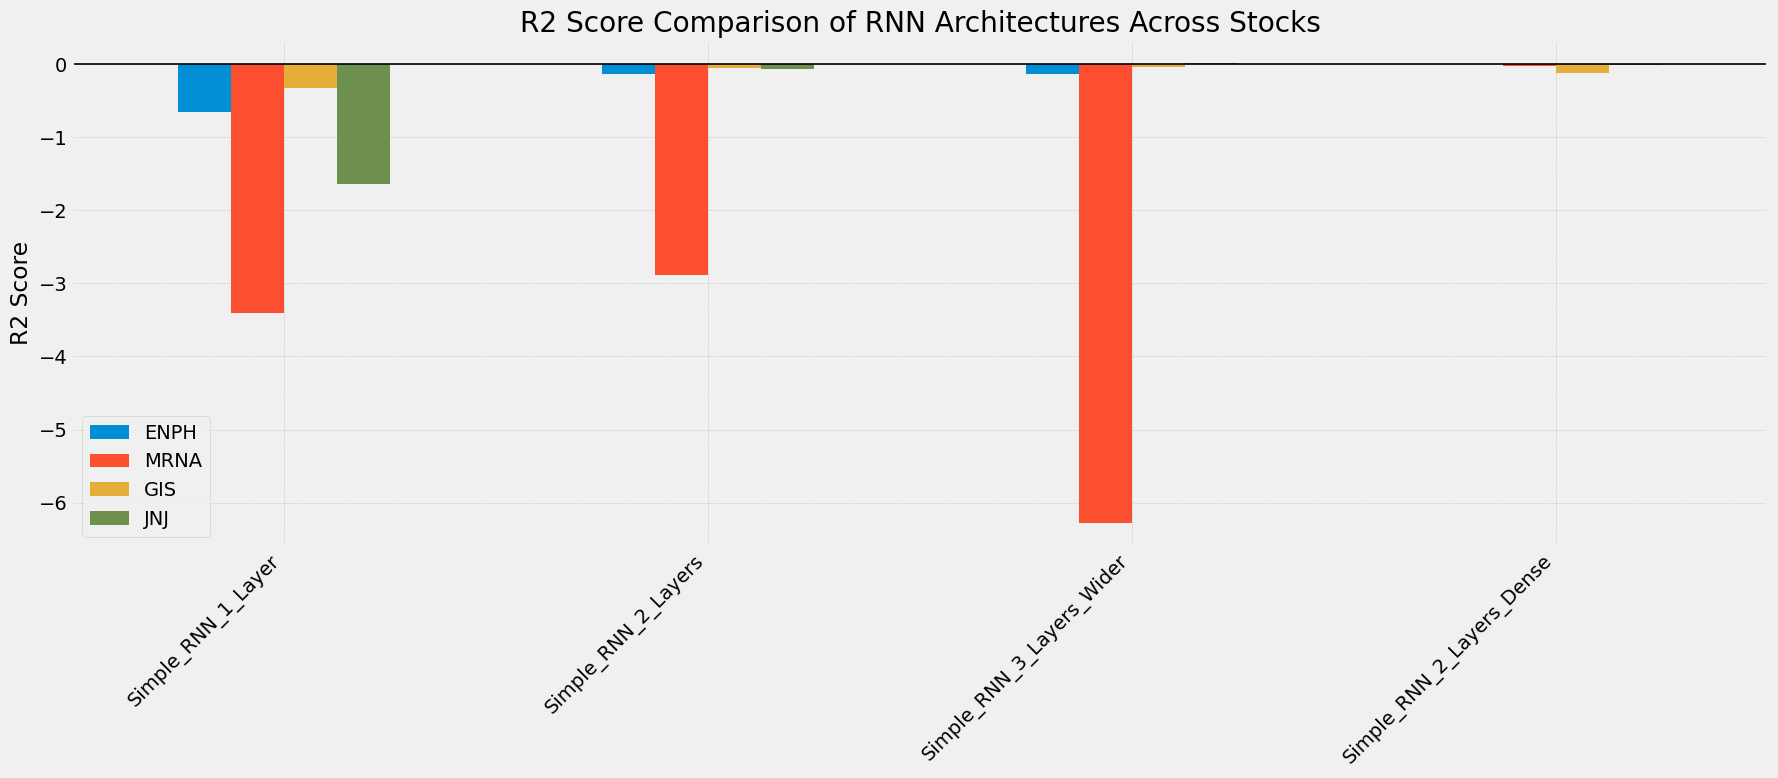

In [5]:
# Reformat the nested dictionary for easier DataFrame creation
reformatted_results = {}
for stock, models in results_summary.items():
    for model_name, metrics in models.items():
        if model_name not in reformatted_results:
            reformatted_results[model_name] = {}
        reformatted_results[model_name][stock] = metrics['R2']

df_r2_comparison = pd.DataFrame(reformatted_results)

print("\n--- Comparison of R2 Scores for RNN Architectures ---")
print(df_r2_comparison)

df_r2_comparison.T.plot(kind='bar', figsize=(18, 8), title='R2 Score Comparison of RNN Architectures Across Stocks')
plt.ylabel('R2 Score')
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(0, color='black', linewidth=1.2, linestyle='-') # Add a line at R2=0
plt.tight_layout()
plt.show()